# Project Title: Furniture Sales Forecast

## Business Objective:

Build a forecast model to predict the furniture sales of a certain store

### Required libraries

In [108]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf

from statsmodels.tsa.statespace.tools import diff

from statsmodels.tsa.seasonal import seasonal_decompose

# pip install pmdarima
from pmdarima.arima import auto_arima

from statsmodels.tsa.arima.model import ARIMA
#SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

from pandas.tseries.offsets import DateOffset

import warnings
warnings.filterwarnings('ignore')

### Import data

In [5]:
#read the dataset
df = pd.read_excel("Proj4_TimeSeries_Sales_Data_Project.xls")
df.tail(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.60,4,0.0,13.320
9993,9994,CA-2017-119914,2017-05-04,2017-05-09,Second Class,CC-12220,Chris Cortes,Consumer,United States,Westminster,...,92683,West,OFF-AP-10002684,Office Supplies,Appliances,"Acco 7-Outlet Masterpiece Power Center, Wihtou...",243.16,2,0.0,72.948


### Data Prepration

In [6]:
#the dimension of the data
df.shape

(9994, 21)

In [13]:
#summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [10]:
#structure of dataset

#category type variable

df.describe(include = "O")

,Order ID,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994
unique,5009,4,793,793,3,1,531,49,4,1862,3,17,1850
top,CA-2017-100111,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope
freq,14,5968,37,37,5191,9994,915,2001,3203,19,6026,1523,48


In [11]:
#numeric and continuous variable
df.describe(include = 'float64')

,Sales,Discount,Profit
count,9994.000000,9994.000000,9994.000000
mean,229.858001,0.156203,28.656896
std,623.245101,0.206452,234.260108
min,0.444000,0.000000,-6599.978000
25%,17.280000,0.000000,1.728750
50%,54.490000,0.200000,8.666500
75%,209.940000,0.200000,29.364000
max,22638.480000,0.800000,8399.976000


In [14]:
#integer variable
df.describe(include = 'int64')

,Row ID,Postal Code,Quantity
count,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,3.789574
std,2885.163629,32063.693350,2.225110
min,1.000000,1040.000000,1.000000
25%,2499.250000,23223.000000,2.000000
50%,4997.500000,56430.500000,3.000000
75%,7495.750000,90008.000000,5.000000
max,9994.000000,99301.000000,14.000000


In [17]:
#all columns
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [22]:
#the time span
print("Minimum time span:",df['Order Date'].min())

print("Maximum time span:", df['Order Date'].max())

Minimum time span: 2014-01-03 00:00:00
Maximum time span: 2017-12-30 00:00:00


In [23]:
#select the features
furni_df = df[["Order Date", "Sales"]]

In [26]:
#sort the order date
furni_df = furni_df.sort_values("Order Date")

In [27]:
#check missing values
furni_df.isnull().sum()

Order Date    0
Sales         0
dtype: int64

There is no missing value exists in the dataset

In [28]:
furni_df = furni_df.groupby("Order Date")['Sales'].sum().reset_index()

In [29]:
furni_df.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158


In [30]:
#set order date as index

furni_df.set_index("Order Date", inplace = True)
furni_df.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06',
               '2014-01-07', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14',
               ...
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1237, freq=None)

In [31]:
#final data

furni_df.head()

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,4407.100
2014-01-07,87.158


In [48]:
funi_sales = furni_df[["Sales"]].resample('MS').mean() #MS mean Month Start

### Visual Inspections of the data

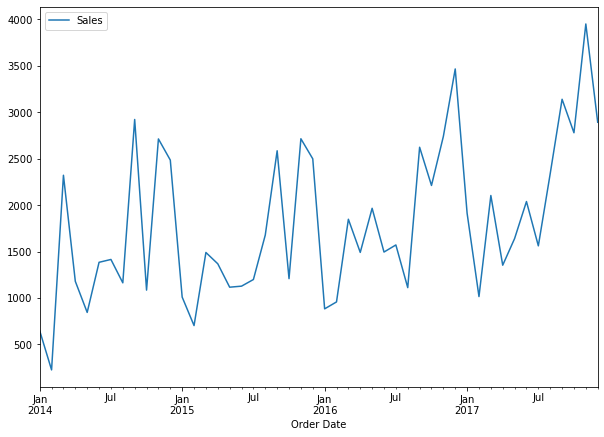

In [50]:
funi_sales.plot(figsize=(10,7))
plt.show()

### View all time series components

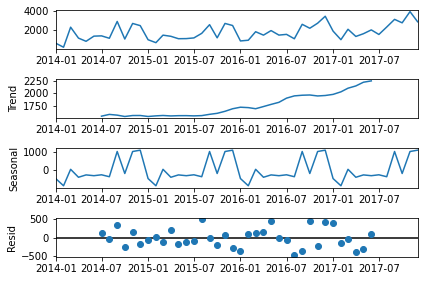

In [54]:
# Check three distinct components: trend, seasonality,and noise
seasonal_decompose(funi_sales).plot();

From the above graph we find that data has trend and seasonality.

### Smooth the data by Moving Average

In [53]:
#Smooth train data
f_sales =  funi_sales[['Sales']]
print(f_sales.head())

                  Sales
Order Date             
2014-01-01   647.131591
2014-02-01   225.994600
2014-03-01  2320.458708
2014-04-01  1178.972708
2014-05-01   844.581679


In [59]:
#took lag 4 as data is day wise
lags = 4
moving_avg = f_sales.rolling(window=lags).mean()

#make a dataframe for actual and smooth data
df_sales = pd.DataFrame({'actual':f_sales['Sales'], 'ma':moving_avg['Sales']})
print(df_sales.head())

                 actual           ma
Order Date                          
2014-01-01   647.131591          NaN
2014-02-01   225.994600          NaN
2014-03-01  2320.458708          NaN
2014-04-01  1178.972708  1093.139402
2014-05-01   844.581679  1142.501924


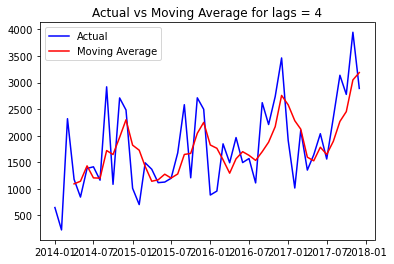

In [60]:
# plot the actual and moving average for comparison
plt.plot(df_sales.actual.dropna(), color='blue',label = 'Actual')
plt.plot(df_sales.ma.dropna(), color='red', label = 'Moving Average')
plt.title('Actual vs Moving Average for lags = ' + str(lags))
plt.legend()
plt.show()

Now, the data is smooth as compare to actual data.

### Check for data stationary

In [61]:
# dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [62]:
# check the data for stationarity
ret=checkStationarity(funi_sales); 
ret

'p-value=6.572451076431882e-05. Data is stationary'

Data is stationary, we can build a model

### Plot ACF and PACF

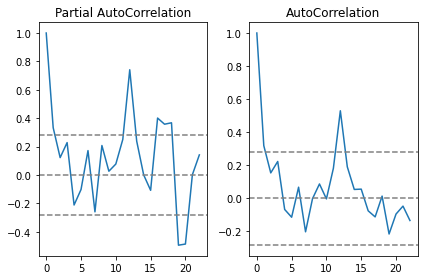

In [64]:
# p -> PACF (partial autocorrelation graph)
# q -> ACF (auto correlation graph)
# d -> differential level (from top)

# since, lags cannot be determined at the beginning, set a random number initially
lag_acf = acf(funi_sales.dropna(), nlags=22)
lag_pacf = pacf(funi_sales.dropna(), nlags=22, method='ols')

# plot PACF (p)
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(funi_sales)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(funi_sales)),linestyle='--',color="gray")
plt.title("Partial AutoCorrelation")

# plot ACF (q)
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(funi_sales)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(funi_sales)),linestyle='--',color="gray")
plt.title("AutoCorrelation")

plt.tight_layout()

### Auto ARIMA for selection of p, d, q

In [65]:
# auto ARIMA (to help in the selection of p,d,q)
auto_arima = auto_arima(funi_sales["Sales"],start_p=0,max_p=2, start_q=0,max_q=2, seasonal=False, trace=True)
print(auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=779.541, Time=0.85 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=770.546, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=777.666, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=766.202, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=768.235, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=765.108, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=769.040, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=766.995, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=764.768, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=763.460, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=764.874, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=766.816, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fi

The lowest AIC = 763.460

Best model:  ARIMA(0,1,1)(0,0,0)[0]  

hence, p = 0, d=1, q=1

### Split the data into train and test¶

In [66]:
# split the data into train and test
ss = int(0.7*len(funi_sales))

train = funi_sales.iloc[:ss]
test = funi_sales.iloc[ss:]
print("train = {}, test = {}".format(len(train), len(test)))

train = 33, test = 15


## Model 1: The ARIMA Model

In [68]:
#Define model

# the values for p and q based on auto_arima recommendation
#Best model: ARIMA(0,1,1)
p=0; d=1; q=1
model_arima = ARIMA(funi_sales["Sales"],order=(p,d,q)).fit()

In [69]:
#summary of the model
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -379.730
Date:                Fri, 25 Nov 2022   AIC                            763.460
Time:                        12:00:06   BIC                            767.161
Sample:                    01-01-2014   HQIC                           764.853
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7090      0.114     -6.233      0.000      -0.932      -0.486
sigma2      6.002e+05   1.33e+05      4.510      0.000    3.39e+05    8.61e+05
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [ ]:
Predict the Sales (test data) using the model

In [70]:
# predictions
start = len(train) 
end = len(train) + len(test) - 1

print('start = {}, end = {}'.format(start,end))

predictions = model_arima.predict(start,end,typ='levels')
print(predictions)

start = 33, end = 47
Order Date
2016-10-01    1803.008857
2016-11-01    1921.632243
2016-12-01    2159.290679
2017-01-01    2539.026964
2017-02-01    2356.507109
2017-03-01    1966.152560
2017-04-01    2005.853352
2017-05-01    1815.774693
2017-06-01    1764.421657
2017-07-01    1843.961197
2017-08-01    1761.575080
2017-09-01    1929.256401
2017-10-01    2281.021566
2017-11-01    2425.565954
2017-12-01    2868.661618
Freq: MS, Name: predicted_mean, dtype: float64


#### Box-Jenkins test to check model's goodness

In [78]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(model_arima.resid, lags=[1], return_df = True)["lb_pvalue"].values

if pvalue<0.05:
    print("reject H0: Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


#### Plot actual vs. predicted values

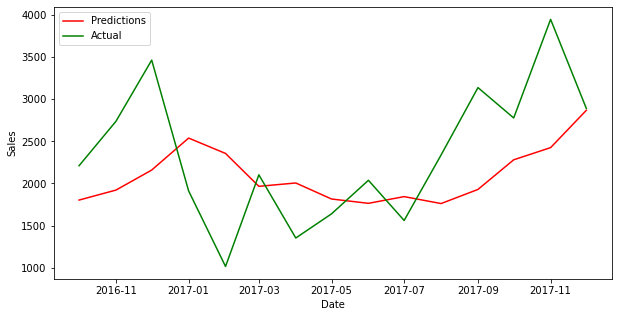

In [77]:
plt.figure(figsize=(10,5))
plt.plot(predictions, 'red', label = 'Predictions')
plt.plot(test, 'green', label='Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

In [79]:
mse1 = mean_squared_error(test,predictions)
print('RMSE: ' + str(np.sqrt(mse1) ))

RMSE: 804.9629971932692


#### Forecast the future data using ARIMA model

In [85]:
# forecast into the future
model_arima1 = ARIMA(funi_sales["Sales"],order=(p,d,q)).fit()
fcast = model_arima1.predict(start=len(train), end=len(train)+6, typ='levels')
print(fcast)

Order Date
2016-10-01    1803.008857
2016-11-01    1921.632243
2016-12-01    2159.290679
2017-01-01    2539.026964
2017-02-01    2356.507109
2017-03-01    1966.152560
2017-04-01    2005.853352
Freq: MS, Name: predicted_mean, dtype: float64


#### Visualize the forecast

Text(0.5, 1.0, 'Funiture Sale Forecasting')

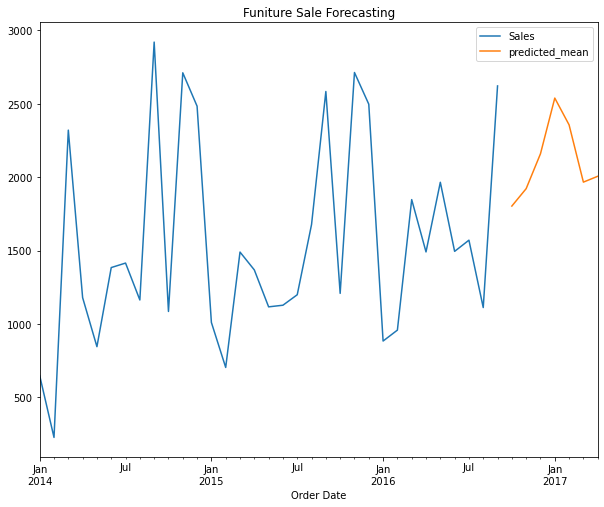

In [91]:
train["Sales"].plot(figsize=(10,8),legend=True)
fcast.plot(legend=True)
plt.title("Funiture Sale Forecasting")

## Model 2: The SARIMA Model

In [87]:
#SARIMA model
#from auto correlation the p,d, q value is , month order i.e 12
p=0; q=1; d=1
model_sarima = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()

In [88]:
#summary of model
print(model_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   33
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -147.689
Date:                            Fri, 25 Nov 2022   AIC                            301.378
Time:                                    12:21:29   BIC                            304.365
Sample:                                01-01-2014   HQIC                           301.961
                                     - 09-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9994     68.213     -0.015      0.988    -134.694     132.695
ma.S.L12      -0.9773     21.709   

In [89]:
forecast = model_sarima.forecast(len(test))
forecast

2016-10-01    1402.452591
2016-11-01    2828.606541
2016-12-01    2546.335250
2017-01-01    1103.361399
2017-02-01     889.266092
2017-03-01    2080.133437
2017-04-01    1583.234541
2017-05-01    1540.508412
2017-06-01    1565.470807
2017-07-01    1623.507577
2017-08-01    1573.212574
2017-09-01    2884.206603
2017-10-01    1517.249322
2017-11-01    2943.403272
2017-12-01    2661.131981
Freq: MS, Name: predicted_mean, dtype: float64

RMSE: 619.8963423331228


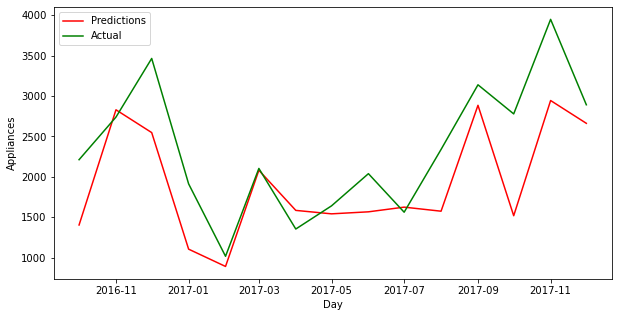

In [90]:
plt.figure(figsize=(10,5))
plt.plot(forecast, 'red', label = 'Predictions')
plt.plot(test, 'green', label='Actual')
plt.xlabel('Day')
plt.ylabel('Appliances')
plt.legend()

mse1 = mean_squared_error(test,forecast)
print('RMSE: ' + str(np.sqrt(mse1) ))

## Model 3: The SARIMAX Model

In [141]:
# df is the original data

#sort the order date
df1 = df.sort_values("Order Date")

In [ ]:

#set order date as index

df1.set_index("Order Date", inplace = True)

In [144]:
#resample the data

DF = df1.resample('MS').mean() #MS mean Month Start
DF.head(2)

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
Order Date,,,,,,
2014-01-01,4381.974684,54965.784810,180.213861,3.594937,0.126582,31.015072
2014-02-01,5918.152174,66299.456522,98.258522,3.456522,0.176087,18.745835


In [181]:
# check the data for stationarity
ret=checkStationarity(DF.Sales); 
ret

'p-value=0.015489720191097567. Data is stationary'

In [171]:
# split the data into train and test
ss = int(0.70 * len(DF))
train_df = DF.iloc[:ss]
test_df = DF.iloc[ss:]

# split into train and test using relevant columns only
train1 = train_df.Sales
test1 = test_df.Sales

print('exog_train = {}, train = {}'.format( len(train1), len(test1)))

exog_train = 33, train = 15


In [ ]:
# check the data for stationarity
ret=checkStationarity(df); 
ret

In [172]:
#split the eXogenous variables
exog_train = train_df[['Quantity', 'Discount', 'Profit']]
exog_test = test_df[['Quantity', 'Discount', 'Profit']]

In [173]:
#preview
print(exog_train.head())

            Quantity  Discount     Profit
Order Date                               
2014-01-01  3.594937  0.126582  31.015072
2014-02-01  3.456522  0.176087  18.745835
2014-03-01  3.726115  0.167516   3.176624
2014-04-01  3.970370  0.110000  25.843224
2014-05-01  3.819672  0.155328  22.448439


In [174]:
print('exog_train = {}, train = {}'.format( len(exog_train), len(train1)))

exog_train = 33, train = 33


In [175]:
#create model
p = 0
d = 1
q = 1
model_sari = SARIMAX(train1, order=(p,d,q), seasonal_order=(p,d,q,12), exog = exog_train.values).fit()

### Forecast values

In [188]:
start = len(train1) 
end = len(train1) + len(test1) - 1

forecast = model_sari.predict(start, end, exog=exog_test.values)
forecast

2016-10-01    128.051947
2016-11-01    248.838725
2016-12-01    218.578043
2017-01-01    180.747206
2017-02-01    328.056069
2017-03-01    290.138038
2017-04-01    231.112144
2017-05-01    274.101110
2017-06-01    205.374582
2017-07-01    186.483512
2017-08-01    130.447346
2017-09-01    206.138234
2017-10-01    173.246966
2017-11-01    249.332842
2017-12-01    238.686844
Freq: MS, Name: predicted_mean, dtype: float64

#### Plot the actual forecasted values

RMSE: 87.54121124191052


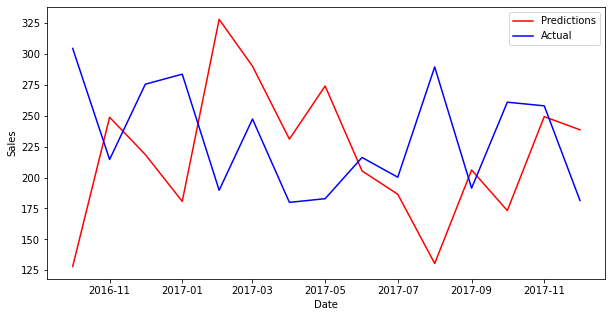

In [184]:
plt.figure(figsize=(10,5))
plt.plot(forecast, 'r', label = 'Predictions')
plt.plot(test_df.Sales, 'b', label='Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

mse1 = mean_squared_error(test_df.Sales,forecast)
print('RMSE: ' + str(np.sqrt(mse1) ))

In [ ]:
#Time series data system, 